# Week 3 Lab Notebook

# Agenda

# (1) HW and Error Bars
# (2) Bayes' Example 1  
# (3) Bayes' Example 2
# (4) Sneak Peak: MCMC

# Scenario 1: The Publishing Graduate Student
In this scenario, you are a graduate student, and have just published a nice article. It’s featured on the journal’s website, and you want to know what the click-through rate is for your article so you can gauge how many people actually want to read your work. That is, you want to know: what is the percentage of visitors to the journal website that will click on the article?

We can think of this like the "infected/not infected" example from class. You know from your friends that typically, between 10% and 25% people who view this journal read articles on this topic, with an average of 17%. You want to model the real clickthrough rate $\theta$ as a binomial. This gives the Likelihood Function:

$$P(D|\theta) = \frac{n!}{(n-k)!k!}\theta^{k}(1-\theta)^{n-k}$$

To encapsulate the prior information (without explicitly using data), you choose a Beta distribution, both because it looks reasonable and is a conjugate prior for the binomial (though once we learn better sampling techniques, we can choose any distribution we want since we will not be constrained by computation!) The one we choose has $\alpha = 20, \beta = 100$:

$$P(\theta) = Beta(\theta,\alpha,\beta) = \frac{\theta^{20-1}(1-\theta)^{100-1}}{\Beta(20,100)}$$

It looks like this:


In [1]:
# Our statistician has told us to import the necessary library in Python first
%matplotlib inline

import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt  
import sklearn
import seaborn
import pymc
from collections import namedtuple

/Users/giridhargopalan/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/giridhargopalan/anaconda/envs/py27/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


(0, 1)

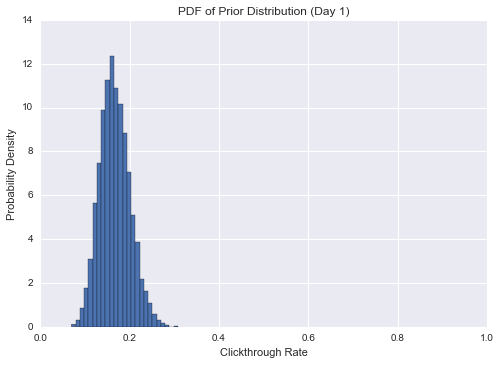

In [4]:
N = 10000

# set shape parameters
betaParamsExample = [20,100]

# sample from the distributions N times
betaDistExample = np.random.beta(betaParamsExample[0],betaParamsExample[1],N)

plt.hist(betaDistExample,25,normed=1)
plt.xlabel("Clickthrough Rate")
plt.ylabel("Probability Density")
plt.title("PDF of Prior Distribution (Day 1)")
plt.xlim(0,1)

On Day 1, 10 visitors have come to the site, and a whopping 80% of them (that is, 8/10 people) read your article! What do you now believe about the clickthrough rate? Well, we calculate the posterior:

$$P(\theta|D) \propto P(D|theta)P(\theta) = Beta(\theta,\alpha+# successes,\beta + # failures) = Beta(\theta,28,102)$$

Here is what it looks like:

(0, 1)

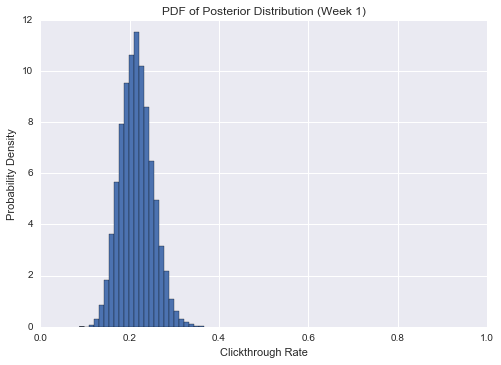

In [3]:
N = 10000
posteriorParamsDay1 = [28,102]
posteriorDistDay1 = np.random.beta(posteriorParamsDay1[0],posteriorParamsDay1[1],N)

plt.hist(posteriorDistDay1,25,normed=1)
plt.xlabel("Clickthrough Rate")
plt.ylabel("Probability Density")
plt.title("PDF of Posterior Distribution (Week 1)")
plt.xlim(0,1)

The distribution certainly shifted to the right, but not by too much! Why not? Because we don't have that much data.

Now, it's a week later, and 1000 new people have come to the site. Your article is really a hit - 560 of them read it! What do you believe about the clickthrough rate now? 

(0, 1)

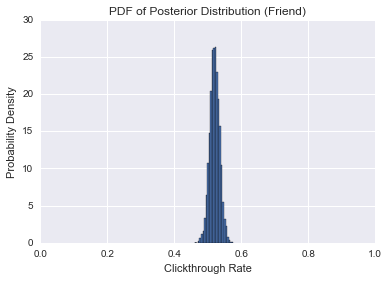

In [46]:
N = 10000
posteriorParamsWeek1 = [28+560,102+440]
posteriorDistWeek1 = np.random.beta(posteriorParamsWeek1[0],posteriorParamsWeek1[1],N)

plt.hist(posteriorDistWeek1,25,normed=1)
plt.xlabel("Clickthrough Rate")
plt.ylabel("Probability Density")
plt.title("PDF of Posterior Distribution (Friend)")
plt.xlim(0,1)

Your friend also published an article in a similar journal, and one week later, 223 of the 502 people who went to the journal page read his article. Not bad! Let's see his posterior distribution.

(0, 1)

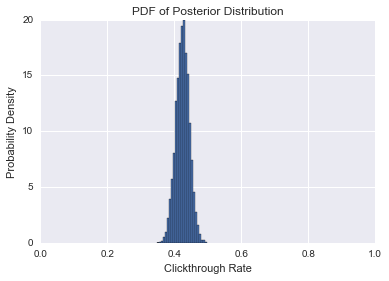

In [40]:
N = 10000
posteriorParamsFriend = [20+223,100+229]
posteriorDistFriend = np.random.beta(posteriorParamsFriend[0],posteriorParamsFriend[1],N)

plt.hist(posteriorDistFriend,25,normed=1)
plt.xlabel("Clickthrough Rate")
plt.ylabel("Probability Density")
plt.title("PDF of Posterior Distribution (Friend)")
plt.xlim(0,1)

Now, here is where we can visually see the power Bayesian method! Remember that we have a full posterior distribution representing our beliefs about the parameters - one for you, and one for your friend. As long as we can simulate this, we can answer all sorts of in-depth questions, not just "what is the most likely estimate of the parameter" (by looking at where the peak is), or even "how strong is my belief in the parameter" (for example, by looking at the standard deviation). We can also see that it is quite unlikely that the two clickthrough rates are the same (there is very little overlap in the two distributions). For an individual distribution, we could also ask things like "what is the probability that the real parameter is between two given values?" So, the computational complexity we gain from this approach translates into more flexibility - a nice payoff in many instances!

Now, let's go to a different example.

(0, 1)

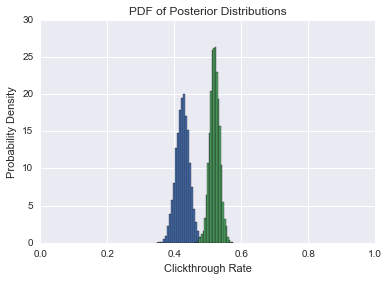

In [48]:
plt.hold(True)
plt.hist(posteriorDistFriend,25,normed=1)
plt.hist(posteriorDistWeek1,25,normed=1)
plt.xlabel("Clickthrough Rate")
plt.ylabel("Probability Density")
plt.title("PDF of Posterior Distributions")
plt.xlim(0,1)


# Scenario Two: Relaxing Conjugacy and a Segue into MCMC
In the previous example, the scenario involved a Beta prior for a probability parameter with a Binomial likelihood. Analytically this is tractable because in this case the posterior also retains a Beta form, making it easy to calculate the posterior distribution. In many cases the analytical tractability that a conjugate prior affords us can be quite useful, as in hierarchical models which we shall see more of in the course.

On the other hand, we may want to try other sorts of priors besides conjugate ones. While the theory behind prior selection is ever evolving (see Jeffreys priors or the reference priors due to Berger and Bernardo for some options besides conugate ones), MCMC methods can be used in the context of Bayesian inference to sample from posterior distributions with arbitrarily specified priors.

As before, we want to model the real clickthrough rate $\theta$ as a binomial. This gives the likelihood function:

$$P(D|\theta) = \frac{n!}{(n-k)!k!}\theta^{k}(1-\theta)^{n-k}$$

Now we use a truncated-Normal for the probability of "success". A truncated-Normal density can be formed by constraining the support of a Normal density to be compact, which in this case is the interval [0,1]. Hence by Bayes' theorem, the posterior is proportional to: 

$$\theta^{k}(1-\theta)^{n-k}exp[-\frac{(\theta-\mu)^2}{2\sigma^2}$$

Which does not have an immediately recognizable density! However, can we still sample from the posterior using MCMC with the pyMC package.

 [-----------------100%-----------------] 10000 of 10000 complete in 2.5 secPlotting theta


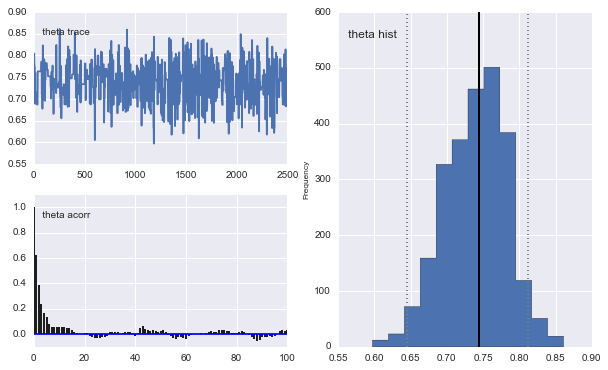

In [15]:
import model
S = pymc.MCMC(model, db='pickle')
S.sample(iter=10000, burn=5000, thin=2)
pymc.Matplot.plot(S)